# Aufgabe 2: Adaptiver Medianfilter
Der Medianfilter aus der vorangegangenen Aufgabe eignet sich besonders, um *Salt-and-Pepper-Rauschen* zu beseitigen.
Scharfe Kanten werden zwar erhalten, Ecken jedoch gestört.
Eine Erweiterung, die noch spezieller auf die Rauschelimination ausgerichtet ist und dabei Ecken weniger beschädigen soll, ist der *adaptive Medianfilter*.

Dabei werden nicht nur Median $z_{med}$, sondern auch minimaler $z_{min}$ und maximaler Grauwert $z_{max}$ sowie der aktuelle Grauwert $z_{xy}$ eines Fensters berücksichtigt.
Folgender Algorithmus wird angewendet:

```
Level A:
   A1 = zmed - zmin
   A2 = zmed - zmax
   If A1 > 0 and A2 < 0, Goto Level B
   Else increase the window size
   If window size < Smax repeat Level A
   Else output zmed
Level B:
   B1 = zxy - zmin
   B2 = zxy - zmax
   If B1 > 0 and B2 < 0 output zxy
   Else output zmed
```

In Stufe A wird sichergestellt, dass der Median selbst kein Minimum oder Maximum im aktuellen Fenster ist, da dies dazu führen würde, ein verrauschtes Pixel zu vervielfältigen.
In Stufe B wird sichergestellt, dass der Median nur angewendet wird, um solche verrauschten Pixel zu eliminieren.

Implementieren Sie den adaptiven Medianfilter und testen Sie Ihre Implementierung auf geeigneten Beispielen!
Für stark verrauschte Bilder empfiehlt sich auch eine mehrfache Anwendung dieses Filters.

## 0. Pfade, Pakete etc.

In [19]:
import glob
import urllib.request

%matplotlib inline
import matplotlib.pyplot as plt

import PIL.Image
import numpy as np

In [20]:
image_filter = '../Bilder/*.jpg'

## 1. Definition der Filter
Hier benötigen wir wieder die Funktionen `max_filter`, `min_filter`, `median_filter` aus der vorherigen Aufgabe.

In [21]:
max_filter = lambda sorted_values: sorted_values[-1]
min_filter = lambda sorted_values: sorted_values[0]
median_filter = lambda sorted_values: sorted_values[len(sorted_values)//2]

## 2. Laden des Bildes

In [22]:
image_path = np.random.choice(glob.glob(image_filter))
image = np.asarray(PIL.Image.open(image_path).convert('L'))

Für diese Aufgabe ist es wichtig, das Bild im Fließkommaformat vorliegen zu haben. Andernfalls kann der Median nicht immer korrekt berechnet werden. Konvertieren sie `image` zu einer geeigneten Repräsentation:

In [23]:
image = image.astype(np.float32)
image -= image.min()
image /= image.max()

# 3. Verrauschen des Bildes
Um ein realistisches Szenario zu simulieren, wird das Bild nun mit Salt-and-Pepper-Rauschen versehen:

In [24]:
image_noisy = np.copy(image)
for _ in range(50000):
    index = tuple([np.random.randint(0,i) for i in image.shape])
    image_noisy[index] = np.random.choice([0.0,1.0])

## 4. Berechung des Filters
Definieren Sie eine Funktion `ex4_adaptive_median_filter`, die ein Bild sowie die maximale Größe der Filtermaske übergeben bekommt und als Rückgabewert das gefilterte Bild liefert. Tipp: verwenden Sie die in 1. definierten Rangordnungsoperatoren.

In [25]:
max_filter = lambda sorted_values: sorted_values[-1]
min_filter = lambda sorted_values: sorted_values[0]
median_filter = lambda sorted_values: sorted_values[len(sorted_values)//2]

def ex4_adaptive_median_filter(image, Smax):
    filtered_image = np.zeros_like(image)
    height, width = image.shape

    # Padding für die Randbehandlung
    pad_size = Smax // 2
    padded_image = np.pad(image, pad_size, mode='edge')

    # Iteriere über jedes Pixel im Originalbild
    for y in range(height):
        for x in range(width):
            # Startfenstergröße ist 3x3
            window_size = 3

            while window_size <= Smax:
                half_size = window_size // 2

                # Extrahiere das aktuelle Fenster aus dem gepaddeten Bild
                y_pad = y + pad_size
                x_pad = x + pad_size
                window = padded_image[y_pad - half_size:y_pad + half_size + 1,
                                     x_pad - half_size:x_pad + half_size + 1]

                # Sortiere die Werte im Fenster
                sorted_values = np.sort(window.flatten())

                # Berechne zmin, zmax, zmed
                z_min = min_filter(sorted_values)
                z_max = max_filter(sorted_values)
                z_med = median_filter(sorted_values)
                z_xy = image[y, x]

                # Level A
                A1 = z_med - z_min
                A2 = z_med - z_max

                if A1 > 0 and A2 < 0:
                    # Goto Level B
                    B1 = z_xy - z_min
                    B2 = z_xy - z_max

                    if B1 > 0 and B2 < 0:
                        # Output zxy
                        filtered_image[y, x] = z_xy
                    else:
                        # Output zmed
                        filtered_image[y, x] = z_med
                    break
                else:
                    # Increase window size
                    window_size += 2

                    if window_size > Smax:
                        # Output zmed
                        filtered_image[y, x] = z_med
                        break

    return filtered_image

Nun wird das gefilterte Bild mit Hilfe der Funktion berechnet:

In [26]:
filtered_image = ex4_adaptive_median_filter(image_noisy, 11)

## 5. Darstellung
Um die Wirksamkeit des adaptiven Medianfilters zu überprüfen, stellen Sie `image`, `image_noisy` und `filtered_image` nebeneinander dar:

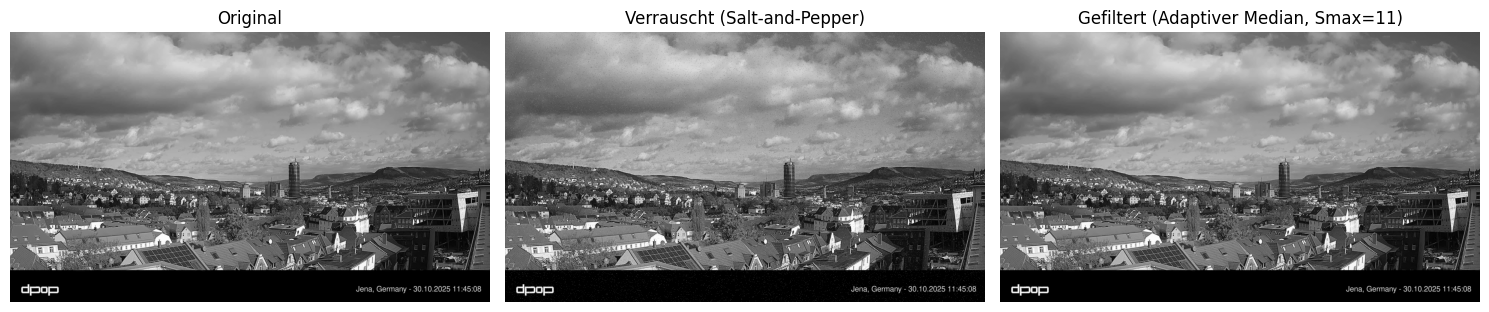

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(image_noisy, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Verrauscht (Salt-and-Pepper)')
axes[1].axis('off')

axes[2].imshow(filtered_image, cmap='gray', vmin=0, vmax=1)
axes[2].set_title(f'Gefiltert (Adaptiver Median, Smax={11})')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Das Rauschen wird erst deutlich, wenn man das Bild vergrößert betrachtet.